# SBND PosRecoCVN Data Reader

Comprehensive notebook to read CNN position reconstruction results from PosRecoCVNProducer output.
Supports both **TTree** (simple analysis) and **PixelMapVars** (detailed analysis) formats.

## Output Format Overview
The PosRecoCVNProducer creates **two complementary data structures**:
1. **`inference_tree`**: Simple TTree with flat variables (recommended for quick analysis)
2. **`PixelMapVars`**: Complex object with PE images, matrices, and detailed physics data

In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

### local

In [3]:
# File path - update this to your pixelmap_variables.root location
file_path = "/exp/sbnd/app/users/svidales/larsoft_develop/run_try/100/ttree_analysis_PosRecoCVNProd-20250918T095707.root"  # Updated for complete data

print(f"Reading file: {file_path}")
print(f"File exists: {Path(file_path).exists()}")
if Path(file_path).exists():
    print(f"File size: {Path(file_path).stat().st_size / 1024:.1f} KB")
else:
    print("❌ File not found! Make sure you've run the job with both TFileService and RootOutput enabled.")

Reading file: /exp/sbnd/app/users/svidales/larsoft_develop/run_try/100/ttree_analysis_PosRecoCVNProd-20250918T095707.root
File exists: True
File size: 15.4 KB


### grid jobs

In [51]:
# File path - update this to your pixelmap_variables.root location
file_path = "/exp/sbnd/data/users/svidales/AI_nuvT_project_support/tools/8k_test_v0912.root"  # Updated for complete data

print(f"Reading file: {file_path}")
print(f"File exists: {Path(file_path).exists()}")
if Path(file_path).exists():
    print(f"File size: {Path(file_path).stat().st_size / 1024:.1f} KB")
else:
    print("❌ File not found! Make sure you've run the job with both TFileService and RootOutput enabled.")

Reading file: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/tools/8k_test_v0912.root
File exists: True
File size: 9384.7 KB


## Only TFileService output (ttree_analysis.root)

Simple, fast analysis using the flat TTree structure. Each row = one event.

In [4]:
# Open file and check for TTree
file = uproot.open(file_path)
print("ROOT file contents:")
for key in file.keys():
    print(f"  - {key}")

# Check subdirectories for TTree (often stored in TFileService subdirectories)
print("\nExploring subdirectories for TTrees:")
subdirs_to_check = []
for key in file.keys():
    try:
        obj = file[key]
        if hasattr(obj, 'keys'):  # It's a directory
            subdirs_to_check.append(key)
            print(f"\n📁 {key} contents:")
            subkeys = obj.keys()
            for subkey in subkeys:
                print(f"    - {subkey}")
                if 'tree' in subkey.lower() or 'inference' in subkey.lower():
                    print(f"      🌲 Found potential tree: {subkey}")
    except:
        continue

# Check if new TTree format exists (check both root level and subdirectories)
has_inference_tree = 'inference_tree' in file.keys()
inference_tree_path = None

if not has_inference_tree:
    # Check in subdirectories
    for subdir in subdirs_to_check:
        try:
            subdir_obj = file[subdir]
            if hasattr(subdir_obj, 'keys'):
                subkeys = subdir_obj.keys()
                for subkey in subkeys:
                    if 'inference_tree' in subkey.lower():
                        has_inference_tree = True
                        inference_tree_path = f"{subdir}/{subkey}"
                        print(f"\n✅ Found TTree at: {inference_tree_path}")
                        break
                if has_inference_tree:
                    break
        except:
            continue

print(f"\nNew TTree format available: {has_inference_tree}")
if inference_tree_path:
    print(f"TTree location: {inference_tree_path}")

# Also check for art framework data products (Events tree)
print(f"\nChecking for art framework data products...")
has_events = 'Events' in file.keys() or any('events' in key.lower() for key in file.keys())
print(f"Events tree available: {has_events}")

# Check if the PixelMapVars product exists in the file
has_pixelmap_vars = False
for key in file.keys():
    if 'PixelMapVars' in key or 'opanatree' in key:
        has_pixelmap_vars = True
        print(f"Found PixelMapVars-related key: {key}")

print(f"PixelMapVars data available: {has_pixelmap_vars}")

# Load the TTree if found
tree = None
if has_inference_tree:
    if inference_tree_path:
        tree = file[inference_tree_path]
    else:
        tree = file['inference_tree']  # fallback for root level
    print(f"\n✅ TTree loaded successfully with {tree.num_entries} entries")

ROOT file contents:
  - opanatree;1
  - opanatree/inference_tree;1
  - MicroBoo znoise;1
  - MicroBoo unoise;1
  - MicroBoo vnoise;1
  - MicroBoo NoiseChan;1
  - Gaussian znoise;1
  - Gaussian unoise;1
  - Gaussian vnoise;1
  - Gaussian NoiseChan;1
  - Cohnoise;1
  - CohNoiseChan;1

Exploring subdirectories for TTrees:

📁 opanatree;1 contents:
    - inference_tree;1
      🌲 Found potential tree: inference_tree;1

📁 opanatree/inference_tree;1 contents:
    - run
    - subrun
    - event
    - passed_filters
    - true_x
    - true_y
    - true_z
    - pred_x
    - pred_y
    - pred_z
    - diff_x
    - diff_y
    - diff_z
    - error_3d
    - nuv_t
    - nuv_z
    - deposited_energy

✅ Found TTree at: opanatree;1/inference_tree;1

New TTree format available: True
TTree location: opanatree;1/inference_tree;1

Checking for art framework data products...
Events tree available: False
Found PixelMapVars-related key: opanatree;1
Found PixelMapVars-related key: opanatree/inference_tree;1
Pixel

In [5]:
if has_inference_tree:
    
    # Read all branches into arrays
    data = tree.arrays(library='pd')  # Read as pandas DataFrame
    
    # Filter events that passed filters
    passed_events = data[data['passed_filters'] == True]
    print(f"\n=== Filter Summary ====")
    print(f"Total events: {len(data)}")
    print(f"Passed filters: {len(passed_events)}")
    print(f"Success rate: {100*len(passed_events)/len(data):.1f}%")
    
    # Show events table - only passed events, and all events if <50
    if len(passed_events) < 50:
        print(f"\n=== All Events That Passed Filters ({len(passed_events)} events) ====")
        display(passed_events.round(2))
    else:
        print(f"\n=== First 10 Events That Passed Filters ====")
        display(passed_events.head(10).round(2))
    
    if len(passed_events) > 0:
        print(f"\n=== Performance Summary ({len(passed_events)} events) ====")
        
        # Calculate performance metrics for events that have predictions
        valid_predictions = passed_events[passed_events['error_3d'] != -999.0]
        
        if len(valid_predictions) > 0:
            coords = ['x', 'y', 'z']
            for coord in coords:
                diff_col = f'diff_{coord}'
                if diff_col in valid_predictions.columns:
                    diff_values = valid_predictions[diff_col].values
                    print(f"* {coord.upper()} coordinate:")
                    print(f"  - Mean difference (Bias): {np.mean(diff_values):6.2f} cm")
                    print(f"  - Std difference:         {np.std(diff_values):6.2f} cm")
                    print(f"  - RMSE:                   {np.sqrt(np.mean(diff_values**2)):6.2f} cm")
                    print(f"  - MAE:                    {np.mean(np.abs(diff_values)):6.2f} cm")
            
        else:
            print("No events with valid predictions found.")
    
else:
    print("❌ TTree format not found. File may be from older version without TTree support.")
    print("Checking if this might be due to old fcl outputCommands...")
    print("Make sure fcl file includes: 'keep *_TFileService_*_*'")


=== Filter Summary ====
Total events: 22
Passed filters: 12
Success rate: 54.5%

=== All Events That Passed Filters (12 events) ====


,run,subrun,event,passed_filters,true_x,true_y,true_z,pred_x,pred_y,pred_z,diff_x,diff_y,diff_z,error_3d,nuv_t,nuv_z,deposited_energy
1,358,91,11,True,146.01,171.63,48.09,143.31,178.24,63.19,-2.70,6.61,15.10,16.71,1276.19,24.84,327.96
5,358,91,31,True,115.67,168.18,438.46,122.68,179.26,448.78,7.01,11.08,10.31,16.68,1006.63,425.86,316.22
6,358,91,33,True,138.32,-55.59,76.14,146.95,-54.02,73.90,8.63,1.57,-2.24,9.06,1392.16,54.41,418.76
8,358,91,43,True,8.04,-187.94,499.54,34.00,-188.86,487.05,25.96,-0.92,-12.49,28.82,422.95,487.02,88.58
9,358,91,46,True,194.59,-198.01,312.41,189.62,-190.38,324.12,-4.98,7.63,11.71,14.83,1233.94,310.16,106.02
10,358,91,48,True,193.66,-181.48,373.37,194.48,-191.30,382.28,0.83,-9.82,8.91,13.28,455.48,380.68,154.51
11,358,91,50,True,95.05,-179.71,147.65,86.04,-181.50,158.10,-9.01,-1.78,10.45,13.91,1395.69,139.62,99.89
14,358,91,67,True,163.12,-90.48,123.37,159.38,-82.24,112.74,-3.74,8.24,-10.62,13.96,859.96,-21.98,575.83
15,358,91,69,True,147.86,78.58,210.29,142.48,72.51,225.47,-5.38,-6.08,15.18,17.22,502.54,179.53,630.18
17,358,91,82,True,108.34,-33.66,28.30,108.22,-30.78,35.09,-0.12,2.88,6.79,7.38,653.98,25.51,415.64



=== Performance Summary (12 events) ====
* X coordinate:
  - Mean difference (Bias):   2.55 cm
  - Std difference:           9.96 cm
  - RMSE:                    10.28 cm
  - MAE:                      7.42 cm
* Y coordinate:
  - Mean difference (Bias):   0.34 cm
  - Std difference:           6.95 cm
  - RMSE:                     6.96 cm
  - MAE:                      6.00 cm
* Z coordinate:
  - Mean difference (Bias):   2.24 cm
  - Std difference:          11.52 cm
  - RMSE:                    11.73 cm
  - MAE:                     10.84 cm


### TTree Visualization

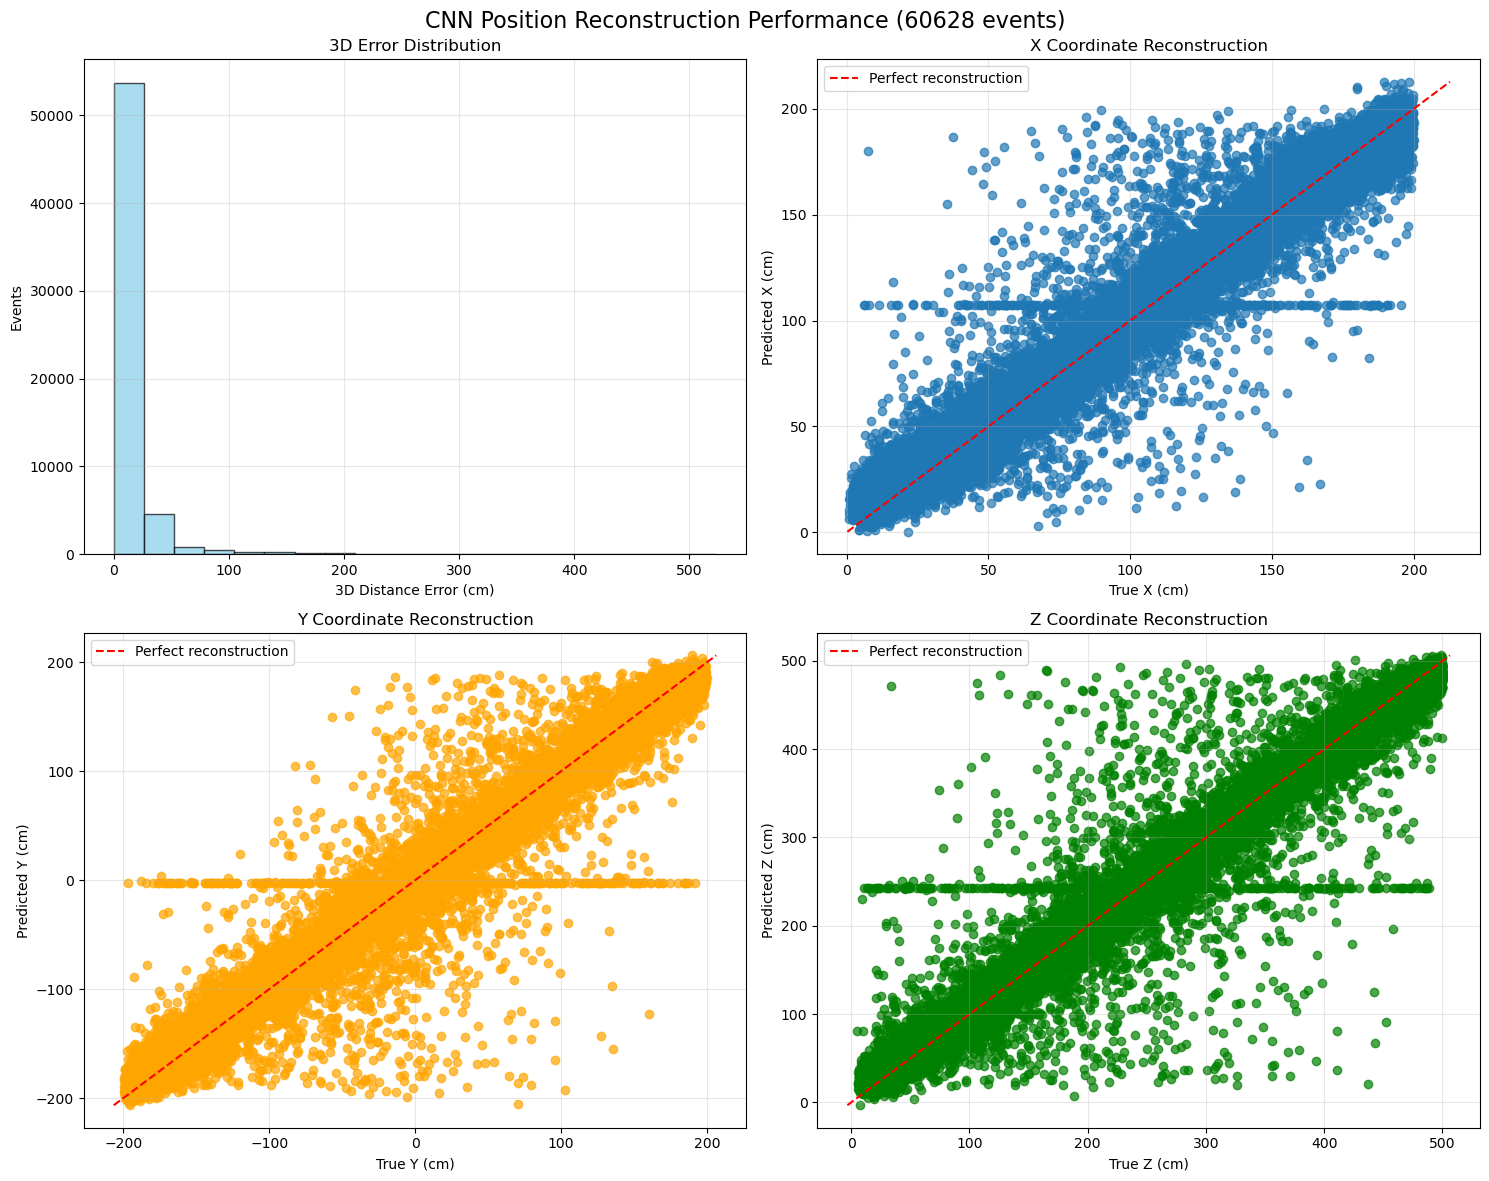

In [54]:
if has_inference_tree and len(passed_events) > 0:
    valid_predictions = passed_events[passed_events['error_3d'] != -999.0]
    
    if len(valid_predictions) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'CNN Position Reconstruction Performance ({len(valid_predictions)} events)', fontsize=16)
        
        # 3D error distribution
        axes[0,0].hist(valid_predictions['error_3d'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_xlabel('3D Distance Error (cm)')
        axes[0,0].set_ylabel('Events')
        axes[0,0].set_title('3D Error Distribution')
        axes[0,0].grid(True, alpha=0.3)
        
        # X coordinate comparison
        axes[0,1].scatter(valid_predictions['true_x'], valid_predictions['pred_x'], alpha=0.7)
        min_x, max_x = min(valid_predictions['true_x'].min(), valid_predictions['pred_x'].min()), max(valid_predictions['true_x'].max(), valid_predictions['pred_x'].max())
        axes[0,1].plot([min_x, max_x], [min_x, max_x], 'r--', label='Perfect reconstruction')
        axes[0,1].set_xlabel('True X (cm)')
        axes[0,1].set_ylabel('Predicted X (cm)')
        axes[0,1].set_title('X Coordinate Reconstruction')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Y coordinate comparison
        axes[1,0].scatter(valid_predictions['true_y'], valid_predictions['pred_y'], alpha=0.7, color='orange')
        min_y, max_y = min(valid_predictions['true_y'].min(), valid_predictions['pred_y'].min()), max(valid_predictions['true_y'].max(), valid_predictions['pred_y'].max())
        axes[1,0].plot([min_y, max_y], [min_y, max_y], 'r--', label='Perfect reconstruction')
        axes[1,0].set_xlabel('True Y (cm)')
        axes[1,0].set_ylabel('Predicted Y (cm)')
        axes[1,0].set_title('Y Coordinate Reconstruction')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Z coordinate comparison
        axes[1,1].scatter(valid_predictions['true_z'], valid_predictions['pred_z'], alpha=0.7, color='green')
        min_z, max_z = min(valid_predictions['true_z'].min(), valid_predictions['pred_z'].min()), max(valid_predictions['true_z'].max(), valid_predictions['pred_z'].max())
        axes[1,1].plot([min_z, max_z], [min_z, max_z], 'r--', label='Perfect reconstruction')
        axes[1,1].set_xlabel('True Z (cm)')
        axes[1,1].set_ylabel('Predicted Z (cm)')
        axes[1,1].set_title('Z Coordinate Reconstruction')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

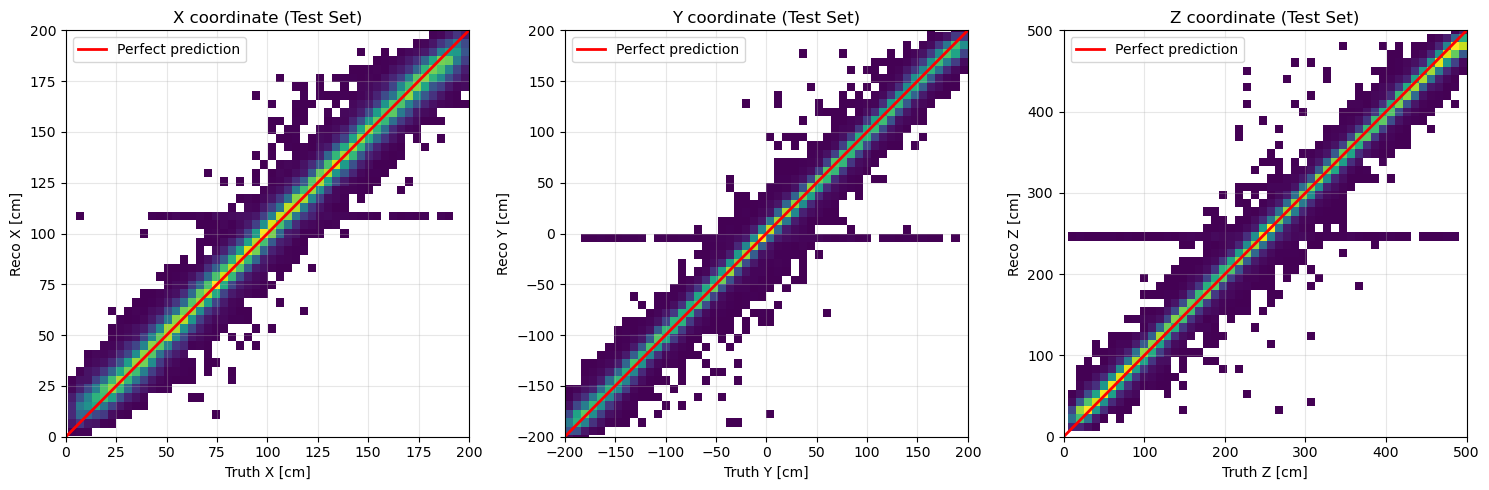

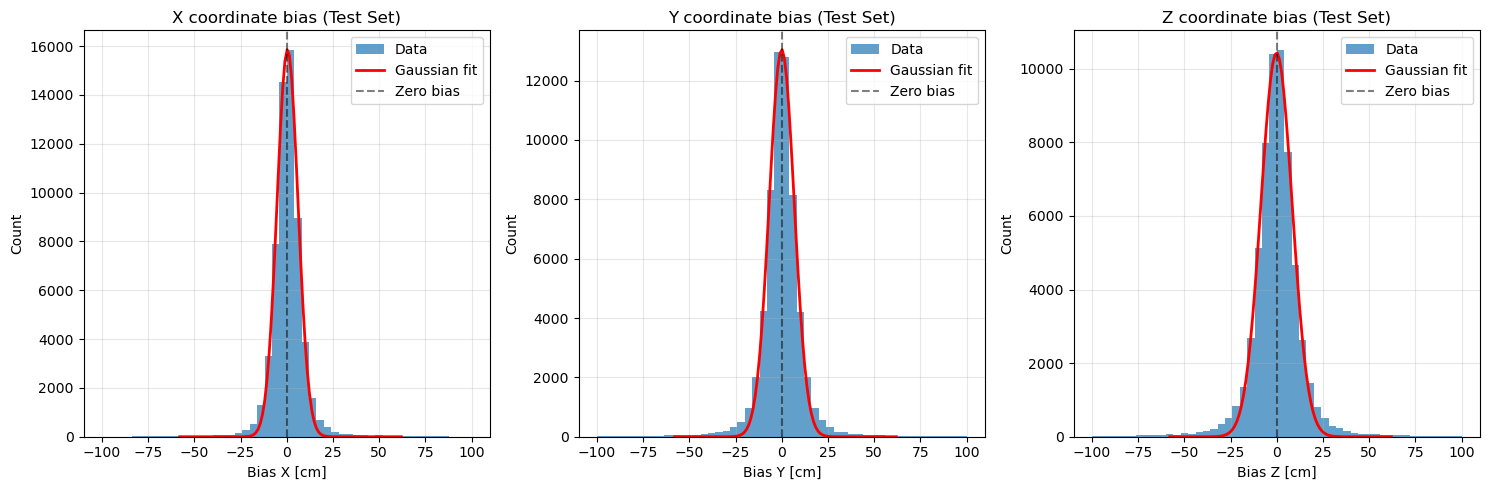


>> Test Set Bias Analysis Results:
* X coordinate:
  - Mean bias: 0.38 cm
  - Resolution (σ): 5.67 cm

* Y coordinate:
  - Mean bias: -0.06 cm
  - Resolution (σ): 6.76 cm

* Z coordinate:
  - Mean bias: -0.16 cm
  - Resolution (σ): 8.47 cm



In [55]:
# Advanced Analysis Plots - Reco vs Truth and Bias Analysis
if has_inference_tree and len(passed_events) > 0:
    from scipy.optimize import curve_fit
    
    valid_predictions = passed_events[passed_events['error_3d'] != -999.0]
    
    if len(valid_predictions) > 0:
        # Extract truth and predicted coordinates
        y_test_original = np.column_stack([
            valid_predictions['true_x'].values,
            valid_predictions['true_y'].values, 
            valid_predictions['true_z'].values
        ])
        
        y_pred_original = np.column_stack([
            valid_predictions['pred_x'].values,
            valid_predictions['pred_y'].values,
            valid_predictions['pred_z'].values
        ])
        
        # Configuration for plots
        ANALYSIS_CONFIG = {
            'reco_truth_comparison': {
                'bins': 50,
                'cmap': 'viridis'
            },
            'bias_analysis': {
                'hist_bins': 50,
                'hist_ranges': {
                    'X': (-100, 100),
                    'Y': (-100, 100), 
                    'Z': (-100, 100)
                },
                'fit_ranges': {
                    'X': (10, 40),
                    'Y': (10, 40),
                    'Z': (10, 40)
                }
            }
        }
        
        # Reco vs Truth comparison plots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        coord_names = ['X', 'Y', 'Z']
        coord_limits = [(0, 200), (-200, 200), (0, 500)]

        for i, (coord, limits) in enumerate(zip(coord_names, coord_limits)):
            hist, xedges, yedges = np.histogram2d(
                y_test_original[:, i],
                y_pred_original[:, i],
                bins=ANALYSIS_CONFIG['reco_truth_comparison']['bins']
            )
            
            hist_masked = np.ma.masked_where(hist <= 2, hist)
            
            im = axs[i].pcolormesh(
                xedges, yedges, hist_masked.T,
                cmap=ANALYSIS_CONFIG['reco_truth_comparison']['cmap'],
                shading='auto'
            )
            
            axs[i].plot(limits, limits, 'r-', linewidth=2, label='Perfect prediction')
            axs[i].set_xlim(limits)
            axs[i].set_ylim(limits)
            axs[i].set_xlabel(f'Truth {coord} [cm]')
            axs[i].set_ylabel(f'Reco {coord} [cm]')
            axs[i].set_title(f'{coord} coordinate (Test Set)')
            axs[i].grid(True, alpha=0.3)
            axs[i].legend()

        plt.tight_layout()
        plt.show()
        
        # Calculate differences (bias)
        diff_coords = y_pred_original - y_test_original

        # Gaussian fit function
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

        # Bias analysis plots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        bias_results = {}

        for i, coord in enumerate(coord_names):
            diff = diff_coords[:, i]
            config = ANALYSIS_CONFIG['bias_analysis']
            
            # Create histogram
            counts, bins, _ = axs[i].hist(
                diff, 
                config['hist_bins'], 
                range=config['hist_ranges'][coord],
                alpha=0.7,
                label='Data'
            )
            
            # Prepare for Gaussian fit
            bin_centers = (bins[:-1] + bins[1:]) / 2
            fit_range = config['fit_ranges'][coord]
            
            # Fit Gaussian
            try:
                p0 = [np.max(counts), 0, 50]
                popt, _ = curve_fit(
                    gaussian, 
                    bin_centers[fit_range[0]:fit_range[1]], 
                    counts[fit_range[0]:fit_range[1]], 
                    p0=p0
                )
                
                # Plot fit
                x_fit = np.linspace(bin_centers[fit_range[0]], bin_centers[fit_range[1]], 100)
                y_fit = gaussian(x_fit, *popt)
                axs[i].plot(x_fit, y_fit, 'r-', linewidth=2, label='Gaussian fit')
                
                # Store results
                bias_results[coord] = {
                    'mean': popt[1],
                    'sigma': popt[2]
                }
                
            except Exception as e:
                print(f"! Warning: Could not fit Gaussian for {coord}: {e}")
                bias_results[coord] = {
                    'mean': np.mean(diff),
                    'sigma': np.std(diff)
                }
            
            axs[i].axvline(0, color='black', linestyle='--', alpha=0.5, label='Zero bias')
            axs[i].set_xlabel(f'Bias {coord} [cm]')
            axs[i].set_ylabel('Count')
            axs[i].set_title(f'{coord} coordinate bias (Test Set)')
            axs[i].legend()
            axs[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print bias results
        print("\n>> Test Set Bias Analysis Results:")
        print("=" * 40)
        for coord in coord_names:
            mean = bias_results[coord]['mean']
            sigma = bias_results[coord]['sigma']
            print(f"* {coord} coordinate:")
            print(f"  - Mean bias: {mean:.2f} cm")
            print(f"  - Resolution (σ): {sigma:.2f} cm")
            print()
    
    else:
        print("No valid predictions available for advanced plotting.")
else:
    print("TTree data not available or no events passed filters.")

### Read pixelmap

In [79]:
# WORKING SOLUTION: Load PixelMapVars with tolist() method
file_path = "/exp/sbnd/data/users/svidales/AI_nuvT_project_support/tools/8k_test_images_v0912.root"

print(f"Reading file: {file_path}")
file = uproot.open(file_path)
events_tree = file['Events;1']
print(f"✅ Events tree found with {events_tree.num_entries} entries")

events_data = []

try:
    pixelmap_obj_branch = 'PixelMapVars_opanatree__SBNDPDSProd./PixelMapVars_opanatree__SBNDPDSProd.obj'
    max_events = min(50, events_tree.num_entries)
    
    print(f"Loading first {max_events} events...")
    pixelmap_arrays = events_tree[pixelmap_obj_branch].array(entry_stop=max_events, library='np')
    print(f"✅ Loaded {len(pixelmap_arrays)} PixelMapVars objects")
    
    # Process each event
    for i in range(len(pixelmap_arrays)):
        try:
            pixelmap_obj = pixelmap_arrays[i]
            
            event_data = {
                'pe_images': None,
                'physics': {}
            }
            
            # Access PE images using tolist() method
            try:
                pe_images_stl = pixelmap_obj.member('pe_images')
                
                if len(pe_images_stl) > 0:
                    # Convert STLVector to list, then to numpy array
                    pe_images_list = pe_images_stl.tolist()
                    pe_images_data = np.array(pe_images_list)
                    
                    if i < 3:
                        print(f"\\nEvent {i} - PE images:")
                        print(f"  STL length: {len(pe_images_stl)}")
                        print(f"  Array shape: {pe_images_data.shape}")
                        print(f"  Non-zero elements: {np.count_nonzero(pe_images_data)}")
                    
                    # pe_images_data should now be a proper numpy array
                    if pe_images_data.size > 0:
                        # Handle different possible shapes
                        if len(pe_images_data.shape) == 4 and pe_images_data.shape[0] == 1:
                            # Remove first dimension and transpose to [height, width, coated/uncoated]
                            pe_data = pe_images_data[0]  # Shape: (height, width, 2)
                            event_data['pe_images'] = pe_data
                        elif len(pe_images_data.shape) == 3:
                            # Already in correct format
                            event_data['pe_images'] = pe_images_data
                        else:
                            event_data['pe_images'] = pe_images_data
                        
                        if i < 3 and event_data['pe_images'] is not None:
                            print(f"  Final shape: {event_data['pe_images'].shape}")
                            print(f"  Final non-zero: {np.count_nonzero(event_data['pe_images'])}")
                            if np.count_nonzero(event_data['pe_images']) > 0:
                                print(f"  Min/Max: {event_data['pe_images'].min():.6f} / {event_data['pe_images'].max():.6f}")
                
            except Exception as e:
                if i < 3:
                    print(f"  Error with pe_images: {e}")
            
            # Extract physics variables using tolist()
            physics_vars = ['dEpromx', 'dEpromy', 'dEpromz', 'dEtpc', 'run_id', 'subrun_id', 'event_id']
            for var in physics_vars:
                try:
                    stl_vec = pixelmap_obj.member(var)
                    if len(stl_vec) > 0:
                        values_list = stl_vec.tolist()
                        if len(values_list) > 0:
                            event_data['physics'][var] = values_list[0]  # Get first element
                except:
                    pass
            
            # Set event ID if not found
            if 'event_id' not in event_data['physics']:
                event_data['physics']['event_id'] = i
            
            # Only keep events with valid PE images
            if event_data['pe_images'] is not None and event_data['pe_images'].size > 0:
                events_data.append(event_data)
                
        except Exception as e:
            if i < 5:
                print(f"Error processing event {i}: {e}")
            continue
    
    print(f"\\n✅ Successfully loaded {len(events_data)} events with PE images")
    
    if len(events_data) > 0:
        sample_event = events_data[0]
        print(f"\\nSample event structure:")
        if sample_event['pe_images'] is not None:
            print(f"  PE images shape: {sample_event['pe_images'].shape}")
            print(f"  PE images dtype: {sample_event['pe_images'].dtype}")
            print(f"  Non-zero pixels: {np.count_nonzero(sample_event['pe_images'])}")
            if np.count_nonzero(sample_event['pe_images']) > 0:
                print(f"  Min/Max values: {sample_event['pe_images'].min():.6f} / {sample_event['pe_images'].max():.6f}")
        print(f"  Physics keys: {list(sample_event['physics'].keys())}")
        
        # Show physics values
        for key, value in sample_event['physics'].items():
            print(f"  {key}: {value}")
        
        print(f"\\n🎯 Events available for visualization: {len(events_data)}")
        event_ids = [event["physics"]["event_id"] for event in events_data]
        print(f"Event IDs with PE data: {event_ids[:10]}" + ("..." if len(event_ids) > 10 else ""))
                
    else:
        print("❌ No events with valid PE images found")
        
except Exception as e:
    print(f"Error loading pixelmap data: {e}")
    import traceback
    traceback.print_exc()

Reading file: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/tools/8k_test_images_v0912.root
✅ Events tree found with 154950 entries
Loading first 50 events...
✅ Loaded 50 PixelMapVars objects
\nEvent 0 - PE images:
  STL length: 1
  Array shape: (1, 59, 70, 2)
  Non-zero elements: 0
  Final shape: (59, 70, 2)
  Final non-zero: 0
\n✅ Successfully loaded 22 events with PE images
\nSample event structure:
  PE images shape: (59, 70, 2)
  PE images dtype: float32
  Non-zero pixels: 0
  Physics keys: ['dEpromx', 'dEpromy', 'dEpromz', 'dEtpc', 'event_id']
  dEpromx: 7.7452717076080555
  dEpromy: 49.36805529967375
  dEpromz: 327.64315087873985
  dEtpc: 234.06123875371944
  event_id: 0
\n🎯 Events available for visualization: 22
Event IDs with PE data: [0, 3, 5, 8, 10, 11, 19, 20, 21, 22]...


In [87]:
# WORKING SOLUTION: Load PixelMapVars with tolist() method - LOADING 200 EVENTS
file_path = "/exp/sbnd/data/users/svidales/AI_nuvT_project_support/tools/8k_test_images_v0912.root"

print(f"Reading file: {file_path}")
file = uproot.open(file_path)
events_tree = file['Events;1']
print(f"✅ Events tree found with {events_tree.num_entries} entries")

events_data = []

try:
    pixelmap_obj_branch = 'PixelMapVars_opanatree__SBNDPDSProd./PixelMapVars_opanatree__SBNDPDSProd.obj'
    max_events = min(200, events_tree.num_entries)  # ← CHANGED FROM 50 TO 200
    
    print(f"Loading first {max_events} events...")
    pixelmap_arrays = events_tree[pixelmap_obj_branch].array(entry_stop=max_events, library='np')
    print(f"✅ Loaded {len(pixelmap_arrays)} PixelMapVars objects")
    
    # Process each event
    for i in range(len(pixelmap_arrays)):
        try:
            pixelmap_obj = pixelmap_arrays[i]
            
            event_data = {
                'pe_images': None,
                'physics': {}
            }
            
            # Access PE images using tolist() method
            try:
                pe_images_stl = pixelmap_obj.member('pe_images')
                
                if len(pe_images_stl) > 0:
                    # Convert STLVector to list, then to numpy array
                    pe_images_list = pe_images_stl.tolist()
                    pe_images_data = np.array(pe_images_list)
                    
                    if i < 3:
                        print(f"\\nEvent {i} - PE images:")
                        print(f"  STL length: {len(pe_images_stl)}")
                        print(f"  Array shape: {pe_images_data.shape}")
                        print(f"  Non-zero elements: {np.count_nonzero(pe_images_data)}")
                    
                    # pe_images_data should now be a proper numpy array
                    if pe_images_data.size > 0:
                        # Handle different possible shapes
                        if len(pe_images_data.shape) == 4 and pe_images_data.shape[0] == 1:
                            # Remove first dimension and transpose to [height, width, coated/uncoated]
                            pe_data = pe_images_data[0]  # Shape: (height, width, 2)
                            event_data['pe_images'] = pe_data
                        elif len(pe_images_data.shape) == 3:
                            # Already in correct format
                            event_data['pe_images'] = pe_images_data
                        else:
                            event_data['pe_images'] = pe_images_data
                        
                        if i < 3 and event_data['pe_images'] is not None:
                            print(f"  Final shape: {event_data['pe_images'].shape}")
                            print(f"  Final non-zero: {np.count_nonzero(event_data['pe_images'])}")
                            if np.count_nonzero(event_data['pe_images']) > 0:
                                print(f"  Min/Max: {event_data['pe_images'].min():.6f} / {event_data['pe_images'].max():.6f}")
                
            except Exception as e:
                if i < 3:
                    print(f"  Error with pe_images: {e}")
            
            # Extract physics variables using tolist()
            physics_vars = ['dEpromx', 'dEpromy', 'dEpromz', 'dEtpc', 'run_id', 'subrun_id', 'event_id']
            for var in physics_vars:
                try:
                    stl_vec = pixelmap_obj.member(var)
                    if len(stl_vec) > 0:
                        values_list = stl_vec.tolist()
                        if len(values_list) > 0:
                            event_data['physics'][var] = values_list[0]  # Get first element
                except:
                    pass
            
            # Set event ID if not found
            if 'event_id' not in event_data['physics']:
                event_data['physics']['event_id'] = i
            
            # Only keep events with valid PE images
            if event_data['pe_images'] is not None and event_data['pe_images'].size > 0:
                events_data.append(event_data)
                
        except Exception as e:
            if i < 5:
                print(f"Error processing event {i}: {e}")
            continue
    
    print(f"\\n✅ Successfully loaded {len(events_data)} events with PE images")
    
    if len(events_data) > 0:
        sample_event = events_data[0]
        print(f"\\nSample event structure:")
        if sample_event['pe_images'] is not None:
            print(f"  PE images shape: {sample_event['pe_images'].shape}")
            print(f"  PE images dtype: {sample_event['pe_images'].dtype}")
            print(f"  Non-zero pixels: {np.count_nonzero(sample_event['pe_images'])}")
            if np.count_nonzero(sample_event['pe_images']) > 0:
                print(f"  Min/Max values: {sample_event['pe_images'].min():.6f} / {sample_event['pe_images'].max():.6f}")
        print(f"  Physics keys: {list(sample_event['physics'].keys())}")
        
        # Show physics values
        for key, value in sample_event['physics'].items():
            print(f"  {key}: {value}")
        
        print(f"\\n🎯 Events available for visualization: {len(events_data)}")
        event_ids = [event["physics"]["event_id"] for event in events_data]
        print(f"Event IDs with PE data: {event_ids[:15]}" + ("..." if len(event_ids) > 15 else ""))
        
        # Show some statistics
        pe_counts = [np.count_nonzero(event['pe_images']) for event in events_data]
        energies = [event['physics'].get('dEtpc', 0) for event in events_data]
        
        print(f"\\n📊 Statistics:")
        print(f"  PE pixels range: {min(pe_counts)} - {max(pe_counts)}")
        print(f"  Energy range: {min(energies):.1f} - {max(energies):.1f} MeV")
        print(f"  Events with >40 PE pixels: {sum(1 for pe in pe_counts if pe > 40)}")
                
    else:
        print("❌ No events with valid PE images found")
        
except Exception as e:
    print(f"Error loading pixelmap data: {e}")
    import traceback
    traceback.print_exc()

Reading file: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/tools/8k_test_images_v0912.root
✅ Events tree found with 154950 entries
Loading first 200 events...
✅ Loaded 200 PixelMapVars objects
\nEvent 0 - PE images:
  STL length: 1
  Array shape: (1, 59, 70, 2)
  Non-zero elements: 0
  Final shape: (59, 70, 2)
  Final non-zero: 0
\n✅ Successfully loaded 89 events with PE images
\nSample event structure:
  PE images shape: (59, 70, 2)
  PE images dtype: float32
  Non-zero pixels: 0
  Physics keys: ['dEpromx', 'dEpromy', 'dEpromz', 'dEtpc', 'event_id']
  dEpromx: 7.7452717076080555
  dEpromy: 49.36805529967375
  dEpromz: 327.64315087873985
  dEtpc: 234.06123875371944
  event_id: 0
\n🎯 Events available for visualization: 89
Event IDs with PE data: [0, 3, 5, 8, 10, 11, 19, 20, 21, 22, 23, 24, 26, 27, 28]...
\n📊 Statistics:
  PE pixels range: 0 - 49
  Energy range: 52.6 - 1580.2 MeV
  Events with >40 PE pixels: 88


🎯 Visualizing Event 107
Position: (103.7, -193.5, 41.8) cm
Energy: 175.4 MeV
Active PE pixels: 47/8260


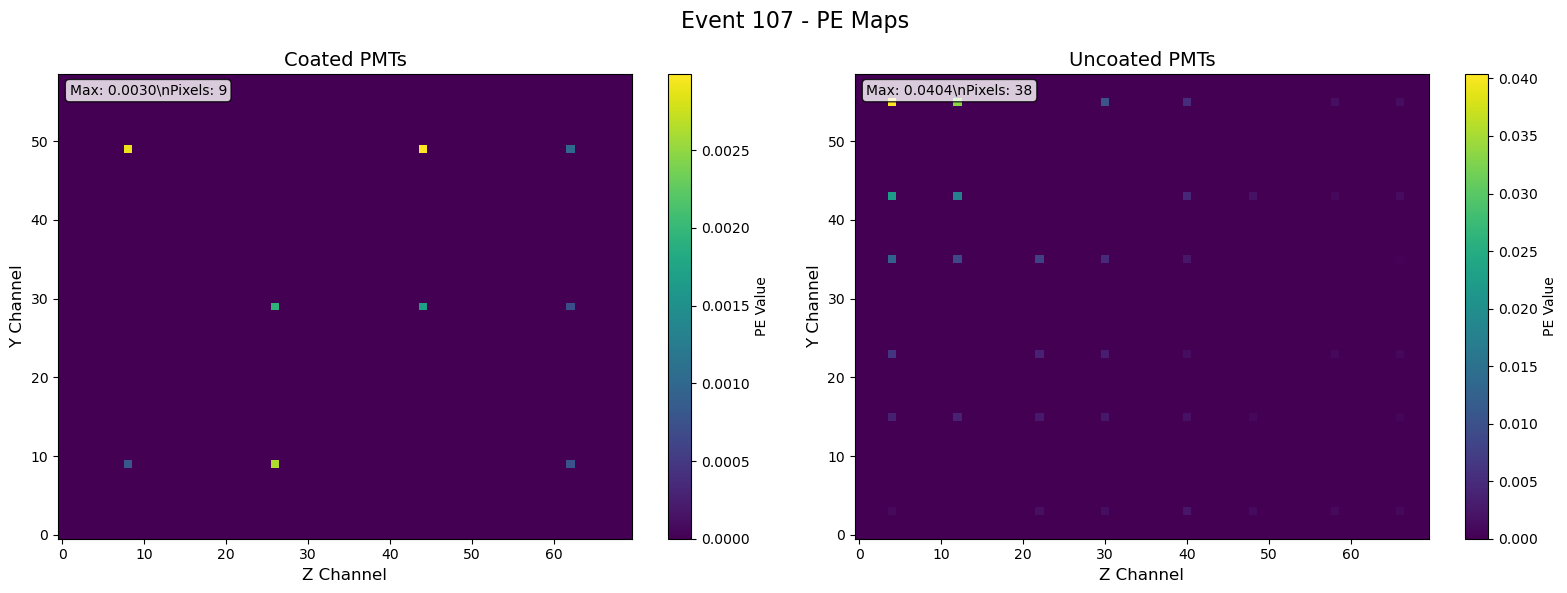

In [93]:
# 🎯 Choose your event to visualize!
# Change the number below to visualize different events

CHOSEN_EVENT_ID = 107  # ← Change this number!

# Visualize the chosen event
if 'events_data' in locals() and len(events_data) > 0:
    visualize_chosen_event(events_data, CHOSEN_EVENT_ID)
else:
    print("❌ No events_data available. Please run the PixelMapVars loading cell first.")